# Hyperparameter Tuning on SageMaker XGBoost algorithm using Porto Seguro Dataset. (Safe Driver prediction)

The notebook shows how to use [Amazon SageMaker's built-in XGBoost algorithm] to predict whether a driver will file an auto insurance claim next year, based on a public dataset provided by an insurance company on Kaggle https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. It leverages hyperparameter tuning to automatically kick off traning jobs with different hyperparameter combinations, to find the one with best model training result.


---
## Data Preprocessing

### Importing Libraries and Permissions and environment variables

Here we set up the linkage and authentication to AWS services.

#### Get the HPO client, which is region specific

In [2]:
import boto3
import os
from sagemaker import get_execution_role
import pandas as pd
import botocore
import string, random

region = boto3.Session().region_name
sagemaker = boto3.Session().client('sagemaker')
role = get_execution_role()
def random_string(size=6, chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

#Specify S3 bucket
bucket = 'sagemaker-walebadr'    
prefix = 'hpo/xgboost'




# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Oi! Have you forgetten to specify the bucket name?'
          ' or maybe your bucket name isn\'t correct!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Oi! You don't have permission to access the bucket, {}. Check the policy permissions".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Oi! This bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Well Done! Training input and output will be stored in: s3://{}/{}'.format(bucket, prefix))

Well Done! Training input and output will be stored in: s3://sagemaker-walebadr/hpo/xgboost


## Inspecting the dataset for some insights
It's really important to get some insights from the dataset before and after the optimization process. This will help a lot in improving the quality of the model and get much more precise results.

First, we will go ahead and gather some insights about our dataset.

### Listing some rows

In [3]:
train = pd.read_csv("./train-1.csv")
train.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


### Counting the rows and columns

In [4]:
rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


### Target distribution

Observation: Target is imbalanced

In [8]:
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

data = [go.Bar(
            x = train["target"].value_counts().index.values,
            y = train["target"].value_counts().values,
            text='Target Distribution'
    )]

layout = go.Layout(
    title='Target distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

### A heatmap of the correlation values
Overvation: Not much correlation between features.

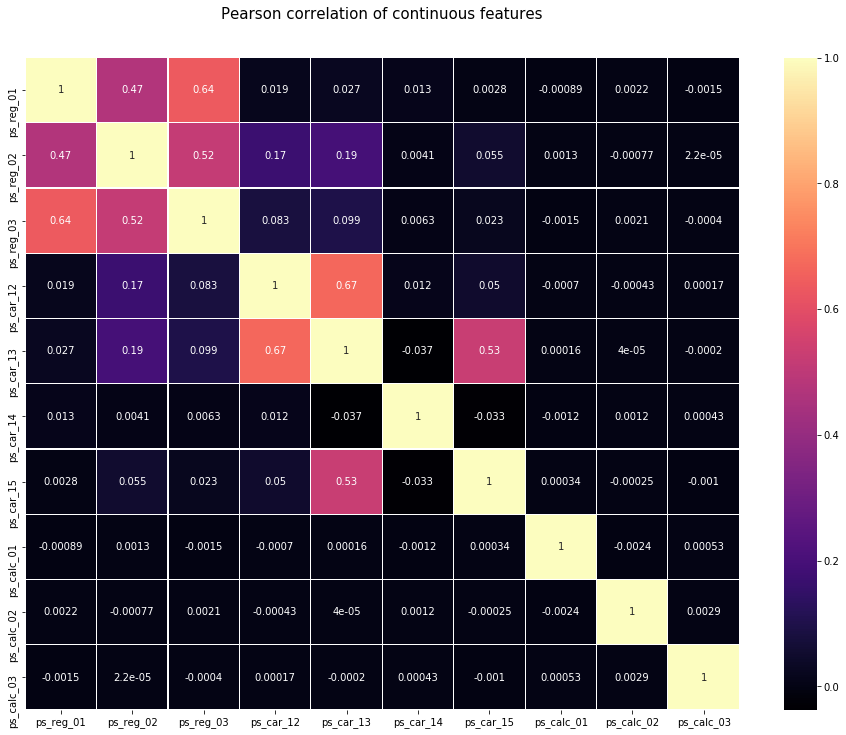

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=False, 
            cmap=colormap, linecolor='white', annot=True)

## Specify hyperparameter tuning job configuration
Now you configure the tuning job by defining a JSON object that you pass as the value of the TuningJobConfig parameter to the create_tuning_job call. In this JSON object, you specify:
* The ranges of hyperparameters you want to tune
* The limits of the resource the tuning job can consume 
* The objective metric for the tuning job


In [10]:
from time import gmtime, strftime, sleep
tuning_job_name = 'xgboost-smworkshop-' + strftime("%d-%H-%M-%S", gmtime())

tuning_job_config = {
    "ParameterRanges": {
      "CategoricalParameterRanges": [],
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta",
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "gamma",
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight",
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth",
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 10,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:auc",
      "Type": "Maximize"
    }
  }

## Specify training job configuration
Now you configure the training jobs the tuning job launches by defining a JSON object that you pass as the value of the TrainingJobDefinition parameter to the create_tuning_job call.
In this JSON object, you specify:
* Metrics that the training jobs emit
* The container image for the algorithm to train
* The input configuration for your training and test data
* Configuration for the output of the algorithm
* The values of any algorithm hyperparameters that are not tuned in the tuning job
* The type of instance to use for the training jobs
* The stopping condition for the training jobs

This example defines two metrics the built-in XGBoost Algorithm emits: valid_auc and train_auc. In this example, we set static values for the eval_metric, auc, num_round, objective, rate_drop, and tweedie_variance_power parameters of the built-in XGBoost Algorithm.

In [11]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
           'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
           'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
            'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}
           
training_image = containers[region]
     
training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": training_image,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": "s3://public-test-hpo-datasets-{}/sagemaker/kaggle/porto-seguro/xgb/train/".format(region)
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": "s3://public-test-hpo-datasets-{}/sagemaker/kaggle/porto-seguro/xgb/val/".format(region)
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}".format(bucket)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.c5.2xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "auc",
      "num_round": "50",
      "objective": "binary:logistic",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}


## Create and launch a hyperparameter tuning job
Now you can launch a hyperparameter tuning job by calling create_tuning_job API. Pass the name and JSON objects you created in previous steps as the values of the parameters. After the tuning job is created, you should be able to describe the tuning job to see its progress in the next step, and you can go to SageMaker console->Jobs to check out the progress of each training job that has been created.

In [12]:
sagemaker.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                            HyperParameterTuningJobConfig = tuning_job_config,
                                            TrainingJobDefinition = training_job_definition)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:625616379791:hyper-parameter-tuning-job/xgboost-smworkshop-07-08-49-51',
 'ResponseMetadata': {'RequestId': 'ec779ce1-09e2-4c85-8f6d-90fda5c132f3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 07 Jul 2018 08:49:51 GMT',
   'x-amzn-requestid': 'ec779ce1-09e2-4c85-8f6d-90fda5c132f3',
   'content-length': '131',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

# WAIT FOR THE TRAINING TO BE COMPLETED FIRST!


## Analyze tuning job results - after tuning job is completed
Once the tuning job is completed (i.e., all training jobs have been finished), we can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric. This is really important because it will show you if the ranges you specified for the hyperparamaters needs to be changed or not (bigger range, different range, smaller range, etc.)

In [16]:
import pandas as pd
from smhpolib import analysis    # analytical library provided through smhpolib, you can find the source code under /smhpolib folder

tuning = analysis.TuningJob(tuning_job_name = tuning_job_name)

HPO_params = tuning.hyperparam_dataframe()

if len(HPO_params) > 0:
    df = HPO_params[HPO_params['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=False)
        print("Valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        best_model = df.iloc[0]
        print("best model information: \n%s" %best_model)
        best_training_job_name = best_model['TrainingJobName']
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("Training jobs launched are not completed yet. Try again in a few minutes.")
        
df

Valid objective: 10
{'lowest': 0.5672150254249573, 'highest': 0.6336129903793335}
best model information: 
FinalObjectiveValue                                               0.633613
TrainingCreationTime                      2018-05-07 21:44:07.910000+00:00
TrainingElapsedTimeSeconds                                         205.935
TrainingEndTime                           2018-05-07 21:47:33.845000+00:00
TrainingJobName               xgboost-sm-workshop-07-21-32-20-010-a794fef8
TrainingJobStatus                                                Completed
eta                                                               0.438106
eval_metric                                                            auc
gamma                                                              6.65705
max_depth                                                                2
min_child_weight                                                   7.99103
num_round                                                           

,FinalObjectiveValue,TrainingCreationTime,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,eta,eval_metric,gamma,max_depth,min_child_weight,num_round,objective,rate_drop,tweedie_variance_power
0,0.633613,2018-05-07 21:44:07.910000+00:00,205.935,2018-05-07 21:47:33.845000+00:00,xgboost-sm-workshop-07-21-32-20-010-a794fef8,Completed,0.438106,auc,6.657054,2.0,7.991031,50.0,binary:logistic,0.3,1.4
8,0.632067,2018-05-07 21:32:33.905000+00:00,220.677,2018-05-07 21:36:14.582000+00:00,xgboost-sm-workshop-07-21-32-20-002-a789e7da,Completed,0.297931,auc,7.609575,7.0,7.928488,50.0,binary:logistic,0.3,1.4
2,0.631693,2018-05-07 21:41:03.318000+00:00,251.298,2018-05-07 21:45:14.616000+00:00,xgboost-sm-workshop-07-21-32-20-008-9630eea1,Completed,0.268654,auc,6.736518,5.0,9.558967,50.0,binary:logistic,0.3,1.4
1,0.631187,2018-05-07 21:43:02.789000+00:00,216.650,2018-05-07 21:46:39.439000+00:00,xgboost-sm-workshop-07-21-32-20-009-81846c18,Completed,0.428106,auc,6.747054,2.0,8.081031,50.0,binary:logistic,0.3,1.4
4,0.625194,2018-05-07 21:37:34.256000+00:00,315.381,2018-05-07 21:42:49.637000+00:00,xgboost-sm-workshop-07-21-32-20-006-a1a6fa31,Completed,0.234279,auc,8.584330,10.0,9.117404,50.0,binary:logistic,0.3,1.4
5,0.625155,2018-05-07 21:37:03.571000+00:00,226.444,2018-05-07 21:40:50.015000+00:00,xgboost-sm-workshop-07-21-32-20-005-8fc481ef,Completed,0.224279,auc,8.674330,10.0,9.207404,50.0,binary:logistic,0.3,1.4
7,0.614199,2018-05-07 21:32:35.652000+00:00,284.817,2018-05-07 21:37:20.469000+00:00,xgboost-sm-workshop-07-21-32-20-003-390105cc,Completed,0.040757,auc,1.896129,4.0,8.946511,50.0,binary:logistic,0.3,1.4
3,0.612136,2018-05-07 21:40:29.464000+00:00,204.714,2018-05-07 21:43:54.178000+00:00,xgboost-sm-workshop-07-21-32-20-007-69d149a0,Completed,0.103715,auc,9.328742,1.0,8.745605,50.0,binary:logistic,0.3,1.4
6,0.584103,2018-05-07 21:36:28.972000+00:00,230.187,2018-05-07 21:40:19.159000+00:00,xgboost-sm-workshop-07-21-32-20-004-f4bfdee4,Completed,0.944688,auc,2.800941,6.0,6.015777,50.0,binary:logistic,0.3,1.4
9,0.567215,2018-05-07 21:32:32.578000+00:00,256.523,2018-05-07 21:36:49.101000+00:00,xgboost-sm-workshop-07-21-32-20-001-0d2d91dd,Completed,0.820338,auc,3.536113,8.0,2.860690,50.0,binary:logistic,0.3,1.4


## See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses

In [17]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
import bokeh.palettes

def big_warp_palette(size, palette_func, warp=1):
    """setting warp < 1 exagerates the high end.
    setting warp > 1 exagerates the low end"""
    p = palette_func(256)
    out = []
    for i in range(size):
        f = i / size # from 0-1 inclusive
        f **= warp
        idx = int(f * 255)
        out.append(p[idx])
    return out

if len(df) > 0:
    palette = big_warp_palette(len(df),bokeh.palettes.plasma, 0.4)
    df['color'] = palette
    hover = smhpolib.viz.SmhpoHover(tuning)

    p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type="datetime")
    p.circle(source=df, x='TrainingCreationTime', y='FinalObjectiveValue', color='color')
    show(p)
else:
    print("Training jobs launched are not completed yet. Try again in a few minutes.")


Loading BokehJS ...

## Analyze the correlation between objective metric and individual hyperparameters 
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For exmaple, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [1]:
# Which hyperparameters to look for correlations for
all_hyperparameters = tuning.hyperparam_ranges().keys()
all_hyperparameters

figures = []
for hp in all_hyperparameters:
    p = figure(plot_width=900, plot_height=500, 
                title="Final objective vs %s" % hp,
                tools=hover.tools(),
                x_axis_label=hp, y_axis_label="objective")
    p.circle(source=df,x=hp,y='FinalObjectiveValue',color='color')
    figures.append(p)
show(bokeh.layouts.Column(*figures))


NameError: name 'tuning' is not defined

## Deploy the best model
Now we are ready to deploy the best model so we can make inferences against it. In order to deploy a model, we have to import the model from training to hosting, then create an endpoint configuration, after that, we create an endpoint using the model and the endpoint configuration we just created.

### Import model into hosting

In [19]:
%%time
from time import gmtime, strftime

model_name=best_training_job_name
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName=best_training_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
hosting_image = training_image  # For XGBoost algorithm, training and hosting share the same image

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data
}

create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

xgboost-sm-workshop-07-21-32-20-010-a794fef8
arn:aws:sagemaker:us-east-1:625616379791:model/xgboost-sm-workshop-07-21-32-20-010-a794fef8
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 630 ms


### Create endpoint configuration
Now, we'll create an endpoint configuration which provides the instance type and count for model deployment.

In [20]:
endpoint_config_name = 'XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.c5.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

XGBoostEndpointConfig-2018-05-07-22-19-27
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:625616379791:endpoint-config/xgboostendpointconfig-2018-05-07-22-19-27


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications.

In [21]:
endpoint_name = 'XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')


XGBoostEndpoint-2018-05-07-22-19-29
arn:aws:sagemaker:us-east-1:625616379791:endpoint/xgboostendpoint-2018-05-07-22-19-29
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:625616379791:endpoint/xgboostendpoint-2018-05-07-22-19-29
Create endpoint ended with status: InService


## Validate the model for use
Finally, you can now validate the model for use by invoking the endpoint you just created and passing in a sample data for prediction

### Get some sample data
You can simiply use the first row in the validation data, which is:

In [22]:
# First row from validation dataset
sample_record="0,5,1,4,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,1.8,2.332648709,10,0,-1,0,0,14,1,1,0,1,104,2,0.445982062,0.879049073,0.40620192,3,0.7,0.8,0.4,3,1,8,2,11,3,8,4,2,0,9,0,1,0,1,1,1"
label,payload = sample_record.split(',',maxsplit=1)

### Run prediction

In [23]:
import json
from itertools import islice
import math
import struct

runtime_client = boto3.client('runtime.sagemaker')

response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = response['Body'].read()
result = float(result.decode("utf-8"))
print ('Label: ',label,'\nPrediction: ', result)

Label:  0 
Prediction:  0.0333758629858
